In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from pythreejs import *
from IPython.display import display

import lorm
from nfft import nfft
import disc.energy_curveling_3d

In [2]:
# load spock data and produce bluerred version of the samples
M = 100
x = np.linspace(-0.5,0.5,M,endpoint=False)
x1,x2,x3 = np.meshgrid(x,x,x)
quat_nodes = np.array([x3.ravel()[:],x1.ravel()[:],x2.ravel()[:]]).transpose()
def compute_spock_voxel_data():    
    sample = 1.2*(np.loadtxt('data/spock.uo')-np.array([0.5,0.5,0.45]))
    mu = np.zeros([M**3],dtype=np.float)
    # generate sampling of blurred spock: "spock_voxel.txt"
    for s in sample:
        mu[:] += np.exp(-30000*((quat_nodes[:,0]-s[1])**2+(quat_nodes[:,1]-s[2])**2+(quat_nodes[:,2]+s[0])**2))
    plt.imshow(mu.reshape([M,M,M])[:,:,10],vmin=0)#,vmax=1)
    np.savetxt('data/spock_voxel.txt',mu)
    
#uncomment if "spock_voxel.txt" not already computed
#compute_spock_voxel_data()

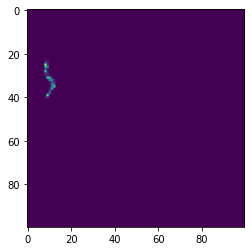

In [3]:
# load the data
mu=np.loadtxt('data/spock_voxel.txt')
M=int(mu.shape[0]**(1./3))+1
plt.imshow(mu.reshape([M,M,M])[:,:,10],vmin=0)#,vmax=1)

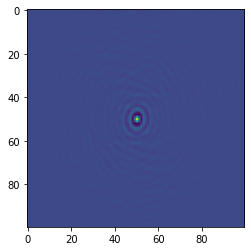

In [5]:
# compute the Fourier coefficients
mu_N_half = 50
nfft3d = nfft.NFFT3D(M**3,2*mu_N_half,2*mu_N_half,2*mu_N_half)
nfft3d.x = quat_nodes
nfft3d.precompute_x()
nfft3d.f = mu/M**3
nfft3d.adjoint()
mu_hat = np.zeros([2*mu_N_half,2*mu_N_half,2*mu_N_half],dtype=complex)
mu_hat[:] = nfft3d.f_hat/nfft3d.f_hat[mu_N_half,mu_N_half,mu_N_half]
plt.imshow(np.real(mu_hat[:,mu_N_half,:]))

In [6]:
# initialize the initial points
e3 = lorm.manif.EuclideanSpace(3)
points = lorm.manif.ManifoldPointArray(e3)
m = 100
points.coords = np.zeros([m,3])
t = np.linspace(0,2*np.pi,m,endpoint=False)
points.coords[:,0] = 0.3*np.sin(t)
points.coords[:,1] = 0.3*np.cos(t)
points.coords[:,2] = 0.3*np.sin(2*t)
points_new = lorm.manif.ManifoldPointArray(e3)

In [7]:
# setup the energy functional
N_half = 8
N=2*N_half
energy = disc.energy_curveling_3d.plan(m,N,0.1,10)
if mu_N_half >= N_half:
    energy._mu_hat[:] = mu_hat[mu_N_half-N_half:mu_N_half+N_half,mu_N_half-N_half:mu_N_half+N_half,mu_N_half-N_half:mu_N_half+N_half]
else:
    energy._mu_hat[N_half-mu_N_half:N_half+mu_N_half,N_half-mu_N_half:N_half+mu_N_half,N_half-mu_N_half:N_half+mu_N_half] = mu_hat[:]

In [8]:
# interactive rendering setup
g1 = BufferGeometry(attributes={'position': BufferAttribute(points.coords.astype(np.float32), normalized=False) })
m1 = LineBasicMaterial(vertexColors='VertexColors', linewidth=3)
line1 = Line(g1,m1)

c = PerspectiveCamera(position=[0, 2, 2], up=[0, 2, 0],
                      children=[DirectionalLight(color='white', position=[3, 5, 1], intensity=0.5)])

scene = Scene(children=[line1, c, AmbientLight(color='#777777')])

renderer = Renderer(camera=c,
                    scene=scene, 
                    controls=[OrbitControls(controlling=c)])
renderer.width =400
renderer.height =400
display(renderer)

def update_points(p):
    g1.attributes['position'].array = p.coords.astype(np.float32)

/home/grman/.local/lib/python3.10/site-packages/jupyter_client/session.py:716: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.5, position=(3.0, 5.0,…

In [10]:
# compute a local minimizer
method = lorm.optim.ConjugateGradientMethod(max_iter=100)
method.listener = update_points
for i in range(5):
    points = method.run(energy,points)

Initial value: f[0] = 0.009309392010005491
f[1] = 0.00930839554159688
f[2] = 0.009307888433977094
f[3] = 0.009307010269227091
f[4] = 0.009304963663160712
f[5] = 0.009301977516341505
f[6] = 0.009300003050846082
f[7] = 0.009298731575906856
f[8] = 0.009298104754420168
f[9] = 0.009297720951884225
f[10] = 0.009297339698725376
f[11] = 0.009296749661026263
f[12] = 0.009295616918925007
f[13] = 0.009293931906375839
f[14] = 0.009291692995053459
f[15] = 0.009288270367608929
f[16] = 0.00928446083376472
f[17] = 0.00928012163373461
f[18] = 0.009277309611729501
f[19] = 0.009275758866082909
f[20] = 0.00927499427477381
f[21] = 0.009274360315581416
f[22] = 0.009273547516026055
f[23] = 0.009271615608153712
f[24] = 0.009268959680058577
f[25] = 0.009264464259615801
f[26] = 0.009259598194978508
f[27] = 0.009256941409790208
f[28] = 0.009255305945889445
f[29] = 0.0092540889679536
f[30] = 0.009253241199095055
f[31] = 0.009252243691332937
f[32] = 0.009250597736318342
f[33] = 0.009248838332821462
f[34] = 0.00924

f[85] = 0.008876077937459611
f[86] = 0.008875550231844238
f[87] = 0.008875046523587594
f[88] = 0.008874516896448836
f[89] = 0.008873835302490184
f[90] = 0.008873130112894798
f[91] = 0.008872398340041967
f[92] = 0.008871753538234125
f[93] = 0.008871115095074678
f[94] = 0.008870425511584177
f[95] = 0.008869871929341785
f[96] = 0.008869397814864236
f[97] = 0.008868974635513964
f[98] = 0.008868468234877629
f[99] = 0.0088680163448787
f[100] = 0.008867624884508037
Reached maximal iterations!
Initial value: f[0] = 0.008867624884508037
f[1] = 0.008867406973073005
f[2] = 0.008867178980940825
f[3] = 0.008867006930959268
f[4] = 0.008866778350919653
f[5] = 0.008866337063806063
f[6] = 0.008865349992576876
f[7] = 0.008862908912229078
f[8] = 0.00886099352915739
f[9] = 0.008859775831580343
f[10] = 0.00885879054828163
f[11] = 0.008858020051850659
f[12] = 0.0088576521019232
f[13] = 0.008857427079675911
f[14] = 0.008857312643283858
f[15] = 0.008857187121128778
f[16] = 0.00885692742328671
f[17] = 0.008856

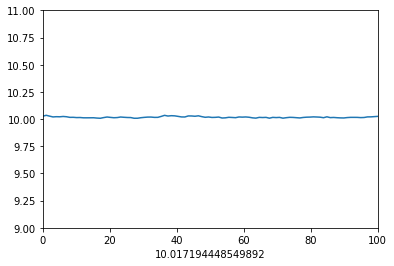

In [11]:
# plot the distance between consecutive points of the curve
#%matplotlib notebook
%matplotlib inline
fig = plt.figure()
bx = fig.add_subplot(111)
bx.axis(np.array([0,m,0.9*energy._L,1.1*energy._L]))
bx.set_xlabel(np.sum(energy._eval_lengths(points.coords)))
distance = plt.Line2D(np.linspace(0,m,m),m*energy._eval_lengths(points.coords))
bx.add_line(distance)

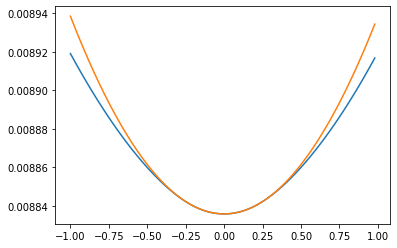

In [12]:
# compute the quadratic approximation to check the gradient and Hessian
%matplotlib inline
v=energy.grad(points)
v.coords = 0.0002*np.random.randn(m,3)
f,q, s = lorm.utils.eval_objective_function_with_quadratic_approximation(energy,v)
plt.plot(s,f,s,q)